In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# DREsS New

In [3]:
dress_new = pd.read_csv('DREsS_New.tsv', sep='\t', index_col=0)
dress_new.shape

(2279, 6)

In [4]:
dress_new.isna().sum()

prompt            0
essay           300
content           0
organization      0
language          0
total           167
dtype: int64

In [5]:
dress_new.drop(columns=['total'], inplace=True)
dress_new.dropna(inplace=True)
dress_new.shape

(1979, 5)

In [6]:
y_cols = dress_new.select_dtypes('number').columns

In [7]:
dress_new.drop_duplicates(subset=['essay'], inplace=True)
dress_new.shape

(1971, 5)

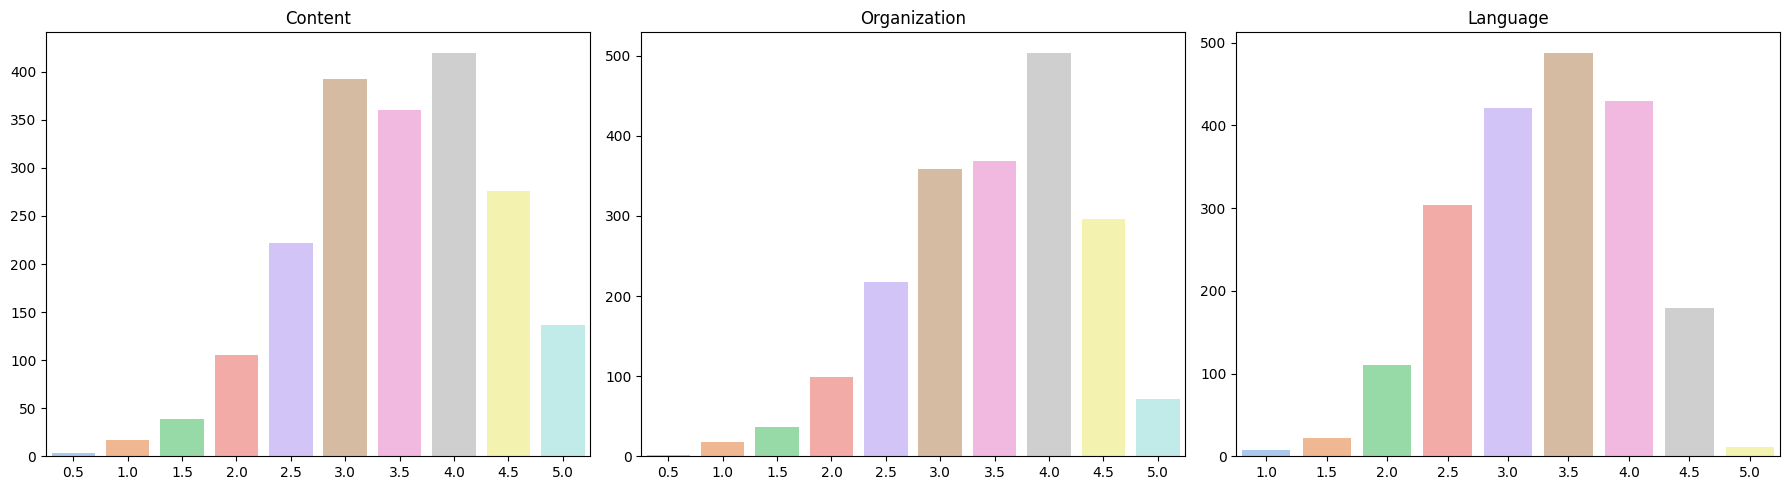

In [8]:
# Side-by-side countplots for grades (1..5) in dress_new
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, col in zip(axes, y_cols):
        sns.countplot(data=dress_new, x=col, ax=ax, palette='pastel', hue=col, legend=False)
        ax.set_title(col.capitalize())
        ax.set_xlabel('')
        ax.set_ylabel('')
plt.tight_layout()
plt.show()

*All three response are left-skewed and highly imbalanced*

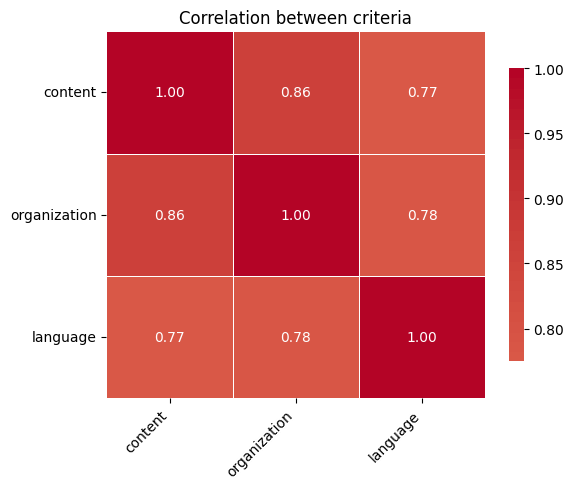

In [9]:
# dress_new.select_dtypes('number').corr().style.background_gradient(cmap='coolwarm')
corr = dress_new[y_cols].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
      linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Correlation between criteria')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

*Content and organisation are very strongly related, while language use relates to each at a somewhat lower, yet strong level*

--- reserved for future experiments with CASE: Lump what author defines as "well-written essays" (all scores >=4.5):

In [10]:
# dress_new.loc[dress_new[y_cols].ge(4.5).all(axis=1), y_cols] = 5

Floor all other scores

In [11]:
dress_new[y_cols] = dress_new[y_cols].astype(int)

In [12]:
# show rows where numeric columns are equal to 0
dress_new.loc[dress_new[y_cols].eq(0).any(axis=1)]


,prompt,essay,content,organization,language
id,,,,,
636,Univeristy: Some people believe that universit...,I used to be a person like to do only what I a...,0,1,2
916,Tech: Some people say that computers have made...,"So far, I think computer makes our life much m...",0,0,2
926,Tech: Some people say that computers have made...,think computers made our lives more convenient...,0,1,2


0 is not sufficiently represented - drop

In [13]:
dress_new = dress_new[dress_new[y_cols].ne(0).all(axis=1)]
dress_new.shape

(1968, 5)

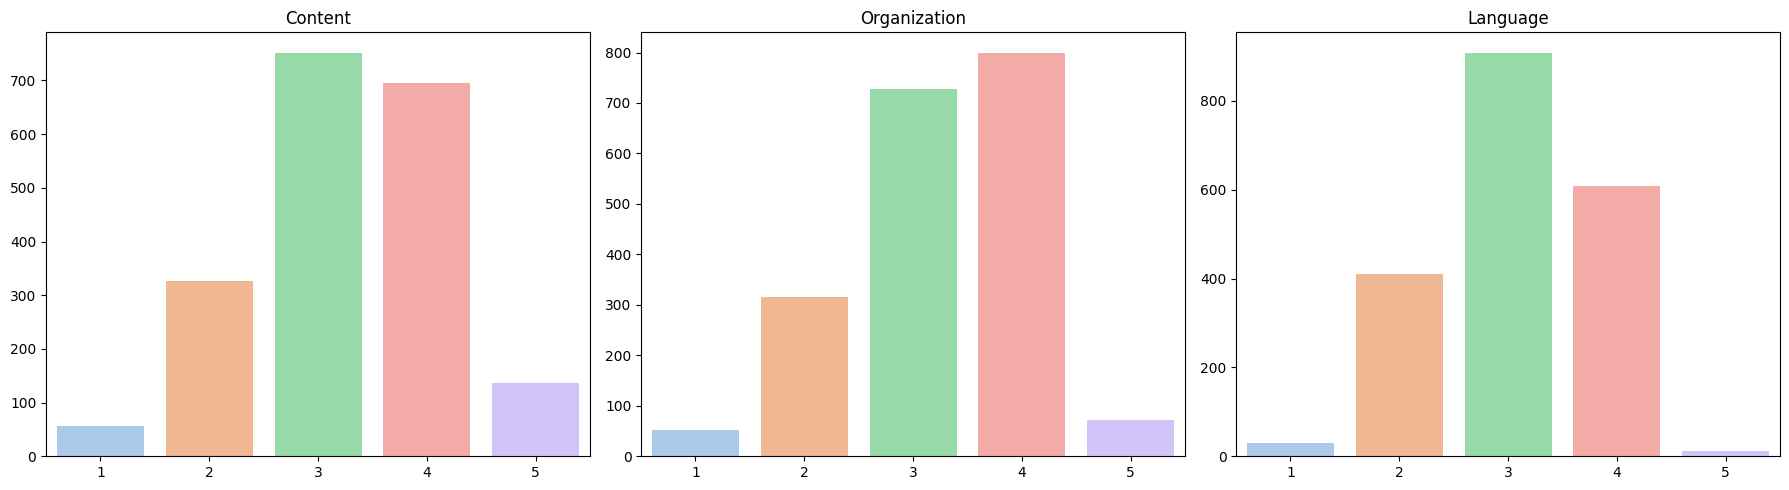

In [14]:
# Side-by-side countplots for grades (1..5) in dress_new
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, col in zip(axes, y_cols):
        sns.countplot(data=dress_new, x=col, ax=ax, palette='pastel', hue=col, legend=False)
        ax.set_title(col.capitalize())
        ax.set_xlabel('')
        ax.set_ylabel('')
plt.tight_layout()
plt.show()

*Collapsing half-marks downward has somewhat centred the distributions, but the issue of imbalance remains.*

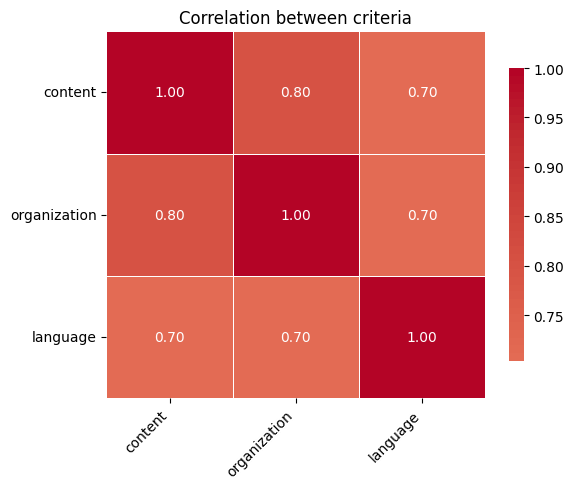

In [15]:
# dress_new.select_dtypes('number').corr().style.background_gradient(cmap='coolwarm')
corr = dress_new[y_cols].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
      linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Correlation between criteria')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

*Pairwise correlations reduced by ~0.08*

#### Text normalization

In [16]:
# Generated with GPT-5 mini

# Conservative Unicode normalization for essays (hardcoded replacements, overwrite original columns)
import unicodedata
import re
import html as _html

# mapping for conservative replacements (hardcoded)
replacements = {
    '\u00A0': ' ',      # NBSP
    '\u2002': ' ',      # en space
    '\u2003': ' ',      # em space
    '\u2018': "'",    # left single smart quote
    '\u2019': "'",    # right single smart quote
    '\u201C': '"',    # left double smart quote
    '\u201D': '"',    # right double smart quote
    '\u2013': '-',     # en dash
    '\u2014': '-',     # em dash
    '\u2026': '...',   # ellipsis
    '\ufb01': 'fi',    # ligatures
    '\ufb02': 'fl',
    '\ufb00': 'ff',
    '\ufb03': 'ffi',
    '\ufb04': 'ffl',
    '\u200B': '',      # zero-width
    '\u200C': '',
    '\u200D': '',
    '\uFEFF': ''
}
# control chars (except newline/tab/carriage)
for code in list(range(0,32)) + list(range(127,160)):
    ch = chr(code)
    if ch in ('\n', '\t', '\r'):
        continue
    replacements.setdefault(ch, '')

rep_pattern = re.compile('|'.join(re.escape(k) for k in sorted(replacements, key=len, reverse=True))) if replacements else None

# HTML handling helpers (preserve inner text)
_br_re = re.compile(r'(?i)<br\s*/?>')
_p_open_re = re.compile(r'(?i)<p\b[^>]*>')
_p_close_re = re.compile(r'(?i)</p>')
_a_re = re.compile(r'(?i)<a\b[^>]*href=["\']([^"\']+)["\'][^>]*>(.*?)</a>', flags=re.S)
_tag_re = re.compile(r'<[^>]+>')


def handle_html(text: str) -> str:
    if not isinstance(text, str):
        return text
    # unescape entities (&amp; &nbsp; etc.)
    text = _html.unescape(text)
    # replace line-like tags
    text = _br_re.sub('\n', text)
    text = _p_open_re.sub('\n\n', text)
    text = _p_close_re.sub('\n\n', text)

    # replace anchors with 'text (URL)'
    def _a_repl(m):
        href = m.group(1).strip()
        inner = m.group(2).strip()
        if inner:
            return f"{inner} ({href})"
        return href
    text = _a_re.sub(_a_repl, text)

    # remove remaining tags but keep inner text
    text = _tag_re.sub('', text)
    return text


def conservative_normalize(text: str) -> str:
    """Normalize a single text string conservatively and return the cleaned text."""
    if not isinstance(text, str):
        return text

    # handle basic HTML entities/tags and preserve inner text
    text = handle_html(text)

    # normalize Unicode compatibility characters
    text = unicodedata.normalize('NFKC', text)

    # apply small replacements
    if rep_pattern:
        text = rep_pattern.sub(lambda m: replacements[m.group(0)], text)

    # replace sequences of spaces/tabs with a single space
    text = re.sub(r"[ \t]+", ' ', text)
    # collapse multiple blank lines to a maximum of two
    text = re.sub(r"\n{3,}", '\n\n', text)
    # strip leading/trailing spaces on each line
    text = '\n'.join([ln.strip() for ln in text.splitlines()])
    return text

# keep copies of originals to compute change counts
orig_essay = dress_new['essay'].copy()
orig_prompt = dress_new['prompt'].copy()

# overwrite with normalized text
dress_new['essay'] = dress_new['essay'].apply(conservative_normalize)
dress_new['prompt'] = dress_new['prompt'].apply(conservative_normalize)

# quick sanity checks: show differences count
print('Essay rows changed:', int((orig_essay != dress_new['essay']).sum()))
print('Prompt rows changed:', int((orig_prompt != dress_new['prompt']).sum()))

# save cleaned file (overwrites original columns in the saved file)
dress_new.to_csv('DREsS_New_cleaned.tsv', sep='\t', index=False)
print("Wrote DREsS_New_cleaned.tsv")


Essay rows changed: 1720
Prompt rows changed: 453
Wrote DREsS_New_cleaned.tsv


Essay word count summary:


count    1968.000000
mean      309.348577
std        94.081169
min        77.000000
25%       244.000000
50%       302.000000
75%       367.250000
max       744.000000
Name: essay_word_count, dtype: float64


Prompt word count summary:


count    1968.000000
mean       29.620427
std        10.649508
min        15.000000
25%        23.000000
50%        26.000000
75%        38.000000
max        59.000000
Name: prompt_word_count, dtype: float64

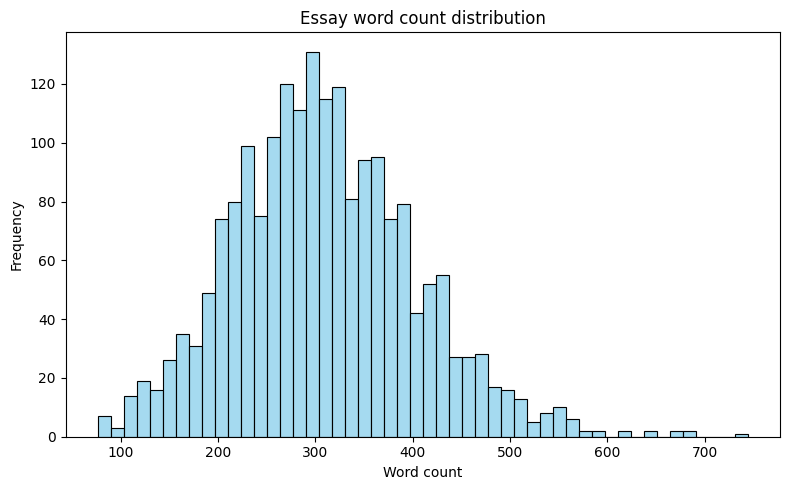

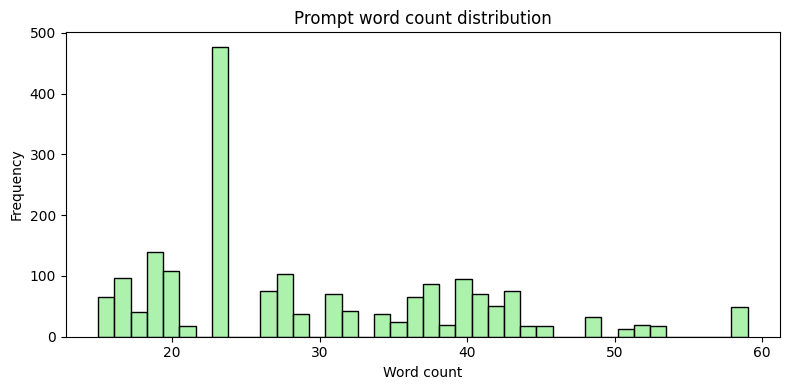

In [17]:
# word counts
# compute word counts for essay and prompt, show summaries and plot histograms
import numpy as np

# ensure text columns exist and compute counts (split on whitespace)
dress_new['essay_word_count'] = dress_new['essay'].fillna('').str.split().str.len()
dress_new['prompt_word_count'] = dress_new['prompt'].fillna('').str.split().str.len()

# summary statistics
print('Essay word count summary:')
display(dress_new['essay_word_count'].describe())
print('\nPrompt word count summary:')
display(dress_new['prompt_word_count'].describe())

# Plot: essay word count distribution (linear y)
plt.figure(figsize=(8, 5))
sns.histplot(dress_new['essay_word_count'], bins=50, color='skyblue', edgecolor='k')
plt.title('Essay word count distribution')
plt.xlabel('Word count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Optional: prompt histogram (smaller, side-by-side)
plt.figure(figsize=(8, 4))
sns.histplot(dress_new['prompt_word_count'], bins=40, color='lightgreen', edgecolor='k')
plt.title('Prompt word count distribution')
plt.xlabel('Word count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# DREsS CASE
--- for future experiments

In [442]:
# Generated with GPT-5 mini

# Repeat cleaning + normalization for DREsS CASE files (overwrite essay/prompt, save as _cleaned.tsv)
cases = ['DREsS_CASE_content.tsv', 'DREsS_CASE_language.tsv', 'DREsS_CASE_organization.tsv']
for fp in cases:
    print('\nProcessing', fp)
    try:
        df = pd.read_csv(fp, sep='\t', index_col=0)
    except Exception as e:
        print('  (read with index_col=0 failed:', e, ') -- retrying without index')
        df = pd.read_csv(fp, sep='\t')
    print('  initial shape:', df.shape)

    # same conservative cleaning as for DREsS_New
    df.drop(columns=['total'], inplace=True, errors='ignore')

    # essay is guaranteed to exist: drop NA and duplicates
    df.dropna(subset=['essay'], inplace=True)
    df.drop_duplicates(subset=['essay'], inplace=True)

    # cast numeric columns to int (rounding/floors handled earlier in notebook)
    num_cols = df.select_dtypes('number').columns.tolist()
    df[num_cols] = df[num_cols].astype(int)
    # drop rows where any numeric column is zero to match earlier scarcity handling
    df.drop(index=df.loc[df[num_cols].eq(0).any(axis=1)].index, inplace=True)
    print('  after cleaning shape:', df.shape)

    # normalization using conservative_normalize from above (must run that cell first)
    if 'conservative_normalize' not in globals():
        raise NameError('conservative_normalize not found - run the normalization cell above before this one')

    # keep originals to report changes and overwrite in-place
    orig_essay = df['essay'].copy()
    df['essay'] = df['essay'].apply(conservative_normalize)
    print('  essay rows changed:', int((orig_essay != df['essay']).sum()))

    # prompt is guaranteed to be present: always normalize and overwrite
    orig_prompt = df['prompt'].copy()
    df['prompt'] = df['prompt'].apply(conservative_normalize)
    print('  prompt rows changed:', int((orig_prompt != df['prompt']).sum()))

    out_clean = fp.replace('.tsv', '_cleaned.tsv')
    df.to_csv(out_clean, sep='\t', index=False)
    print('  wrote', out_clean)



Processing DREsS_CASE_content.tsv
  initial shape: (8307, 3)
  after cleaning shape: (8300, 3)
  essay rows changed: 5251
  prompt rows changed: 540
  wrote DREsS_CASE_content_cleaned.tsv

Processing DREsS_CASE_language.tsv
  initial shape: (792, 3)
  after cleaning shape: (792, 3)
  essay rows changed: 644
  prompt rows changed: 90
  wrote DREsS_CASE_language_cleaned.tsv

Processing DREsS_CASE_organization.tsv
  initial shape: (31086, 3)
  after cleaning shape: (28981, 3)
  essay rows changed: 13773
  prompt rows changed: 1731
  wrote DREsS_CASE_organization_cleaned.tsv


In [443]:
y_cols

Index(['content', 'organization', 'language'], dtype='object')

In [444]:
DREsS_CASE_content_cleaned = pd.read_csv('DREsS_CASE_content_cleaned.tsv', sep='\t', index_col=0)
DREsS_CASE_organization_cleaned = pd.read_csv('DREsS_CASE_organization_cleaned.tsv', sep='\t', index_col=0)
DREsS_CASE_language_cleaned = pd.read_csv('DREsS_CASE_language_cleaned.tsv', sep='\t', index_col=0)

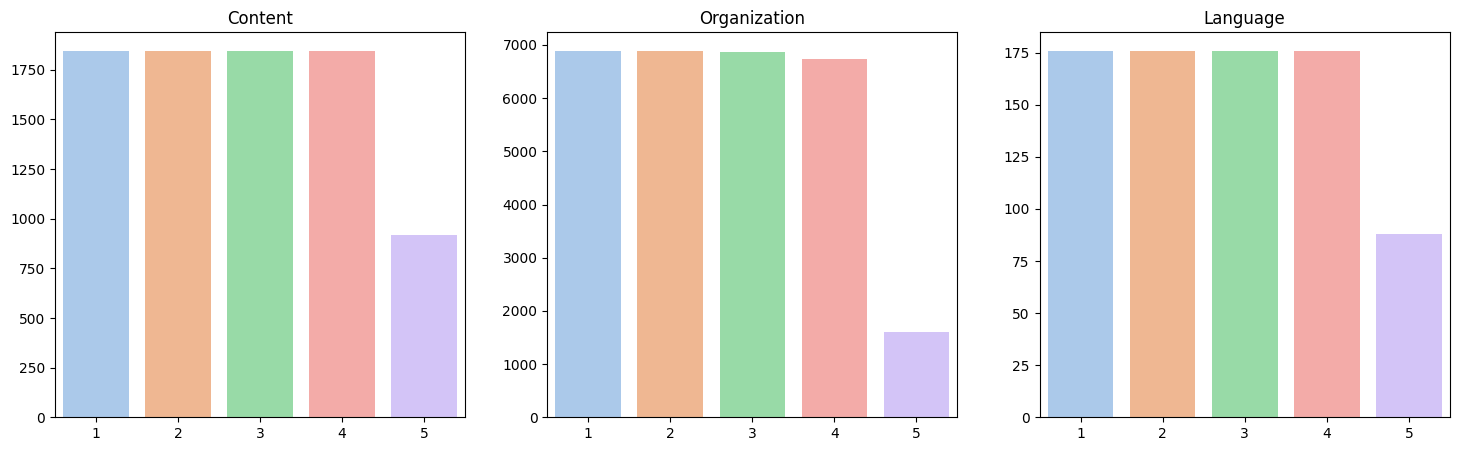

In [448]:
# Combined seaborn countplots for the three CASE datasets side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for col, ds, ax in zip(
  y_cols,
  [DREsS_CASE_content_cleaned, DREsS_CASE_organization_cleaned, DREsS_CASE_language_cleaned],
  axes
  ):
  
  sns.countplot(data=ds, x=col, ax=ax, palette='pastel', legend=False, hue=col)
  ax.set_title(col.capitalize())
  ax.tick_params(axis='x')
  ax.set_ylabel('')
  ax.set_xlabel('')

plt.show()